In [ ]:
!pip install ultralytics
!pip install transformers[torch]
!pip install timm

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision as tt
import matplotlib.pyplot as plt
import requests

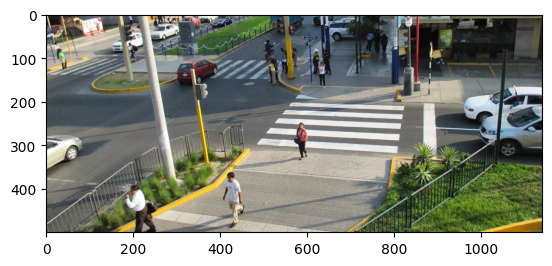

In [ ]:
# Load an image from a URL using PIL Image
from PIL import Image

url = "https://miro.medium.com/v2/resize:fit:3840/format:webp/0*HbaHvX8syDfkB2PX"
url="https://datasets-server.huggingface.co/assets/cats_vs_dogs/--/default/train/45/image/image.jpg"
url="https://i.guim.co.uk/img/media/cbf18c880793fff4e8cdf10a0231c308bd529d9b/0_182_5472_3283/master/5472.jpg?width=620&dpr=2&s=none"
url = "https://blogs.worldbank.org/sites/default/files/styles/hero/public/2022-04/hero-sidewalk.jpg.webp?itok=uUqHncdk"
image = Image.open(requests.get(url, stream=True).raw)

# Display the loaded image
plt.imshow(image)
plt.show()

In [ ]:
# Define a function to get the computing device (CPU in this case)
def get_device():
  return 'cpu'

In [ ]:
# Import necessary transformers and models
from transformers import pipeline
from ultralytics import YOLO
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

# Define a function to provide the desired image segmentation model
def model_provider(model):
  if model=="segformer":
    return pipeline("image-segmentation", "nvidia/segformer-b1-finetuned-cityscapes-1024-1024")
  if model=="yolo":
    return YOLO('yolov8x-seg.yaml').load('yolov8x.pt')
  if model == "mask2former":
    return pipeline("image-segmentation", "facebook/mask2former-swin-base-coco-panoptic")
  if model == "detr":
    return pipeline("image-segmentation", "facebook/detr-resnet-50-panoptic")

In [ ]:
# Set the model type and get the corresponding model
model_type = "detr" # @param ["detr", "mask2former", "yolo", "segformer"]
model = model_provider(model_type)
results = model(image)

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor conf

In [ ]:
# Define a function to find the bounding box of non-zero values in a 2D NumPy array
def find_bounding_box(data):
    """
    Finds the bounding box of non-zero values in a 2D NumPy array.

    Args:
        data (np.ndarray): The 2D NumPy array.

    Returns:
        tuple: The bounding box coordinates (min_row, min_col, max_row, max_col).
    """

    if not isinstance(data, np.ndarray) or data.ndim != 2:
        raise TypeError("Input data must be a 2D NumPy array.")
    # breakpoint()
    data = 255.0 - data
    non_zero_rows = np.where(data.any(axis=1))[0]
    non_zero_cols = np.where(data.any(axis=0))[0]

    if len(non_zero_rows) == 0 or len(non_zero_cols) == 0:
        return None

    min_row = non_zero_rows.min()
    max_row = non_zero_rows.max() + 1
    min_col = non_zero_cols.min()
    max_col = non_zero_cols.max() + 1

    return (min_col, min_row, max_col, max_row)

start mask


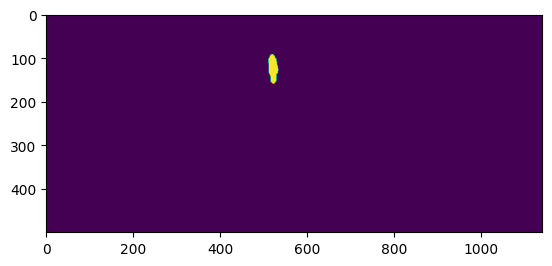

(511, 92, 534, 160)


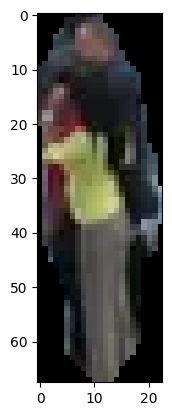

start mask


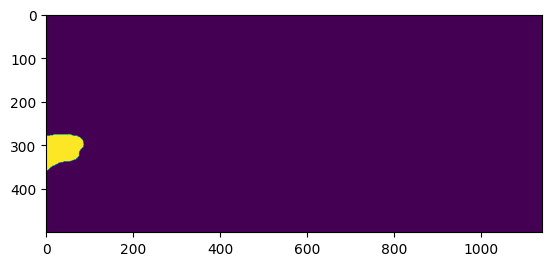

(0, 275, 87, 359)


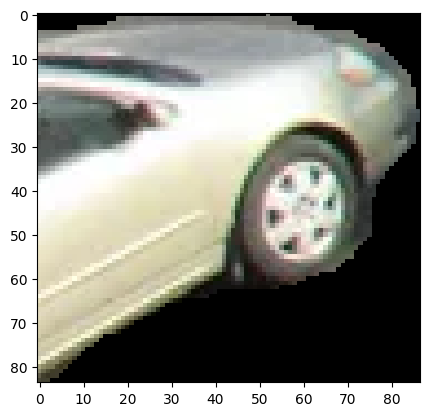

start mask


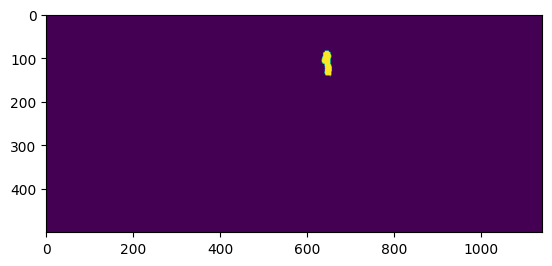

(633, 84, 657, 143)


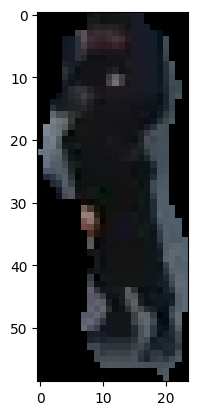

start mask


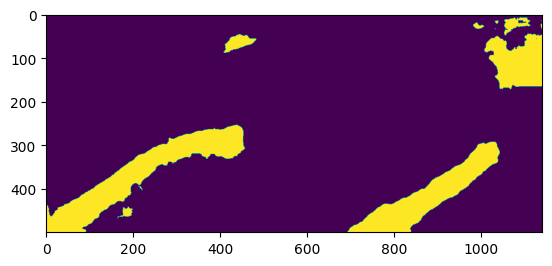

(0, 7, 1140, 500)


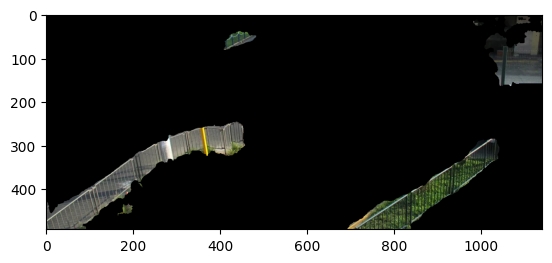

start mask


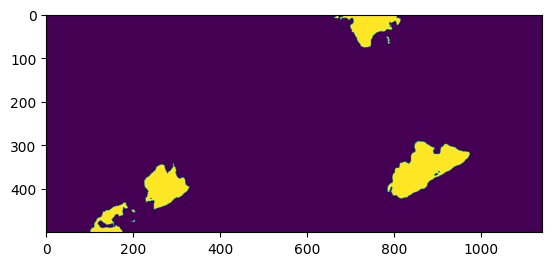

(102, 0, 974, 500)


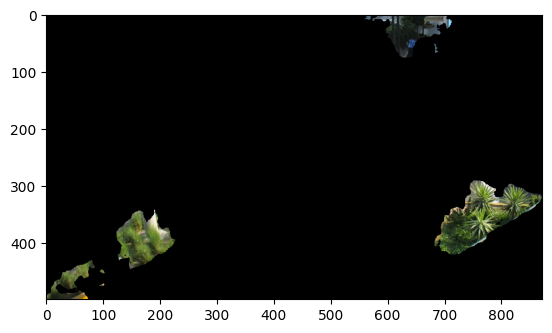

start mask


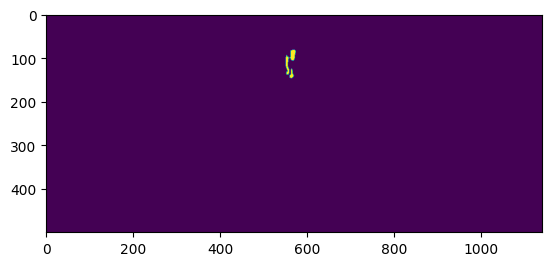

(551, 82, 574, 147)


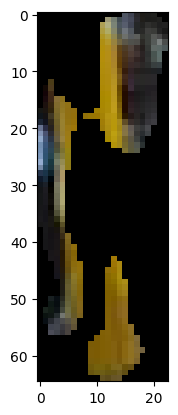

start mask


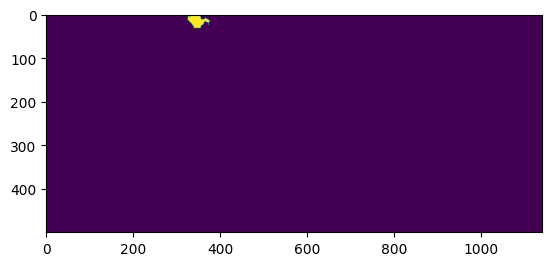

(320, 0, 377, 32)


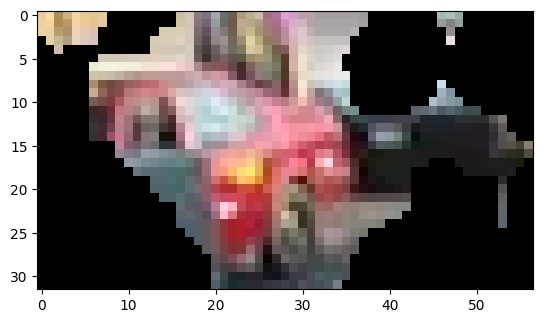

start mask


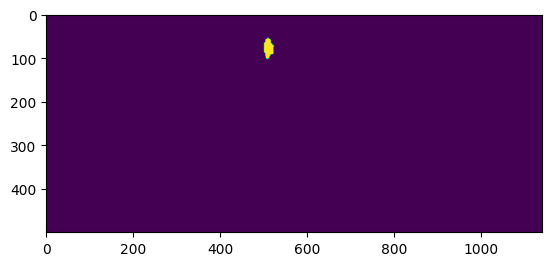

(501, 54, 524, 103)


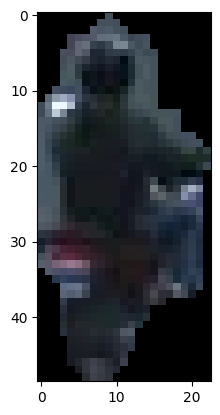

start mask


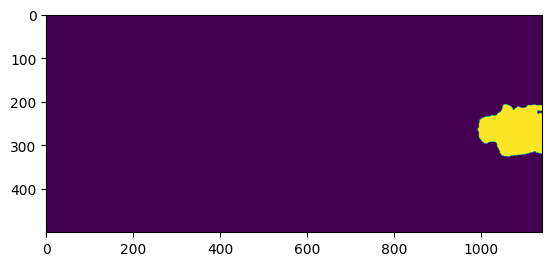

(992, 207, 1140, 327)


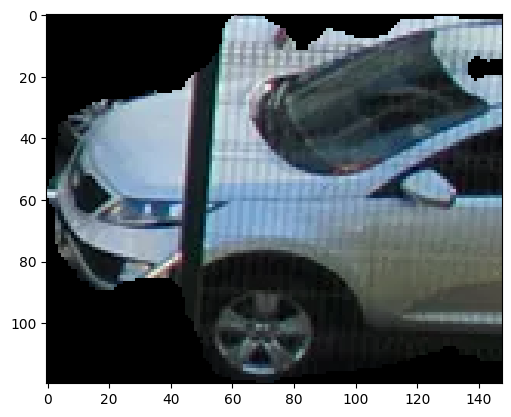

start mask


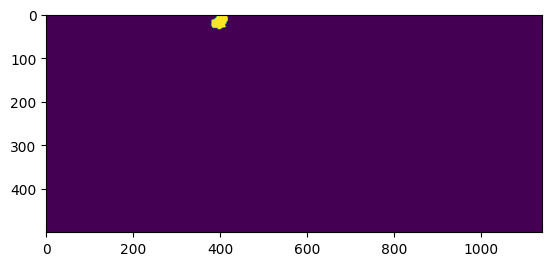

(379, 0, 418, 35)


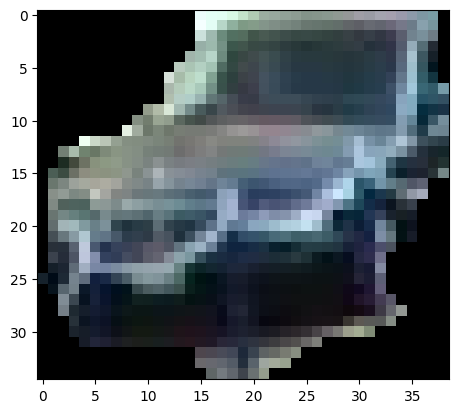

start mask


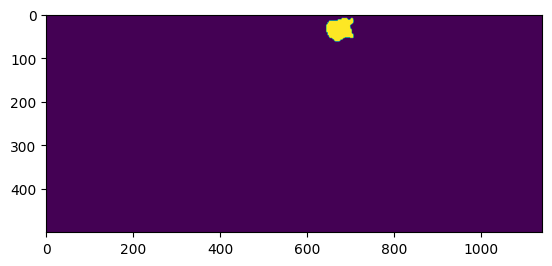

(644, 9, 707, 63)


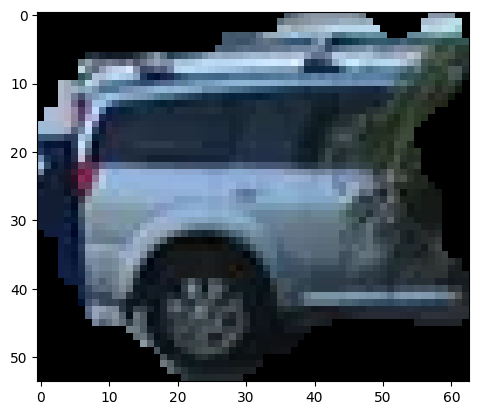

start mask


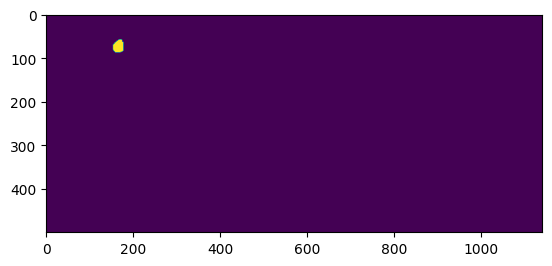

(154, 58, 178, 88)


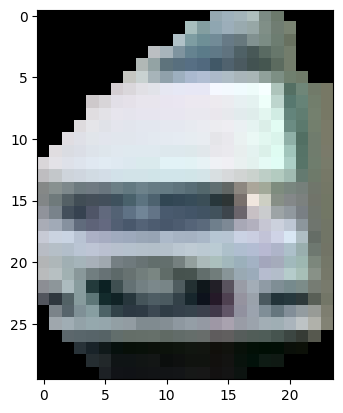

start mask


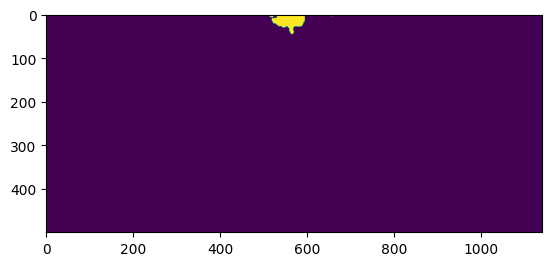

(514, 0, 660, 46)


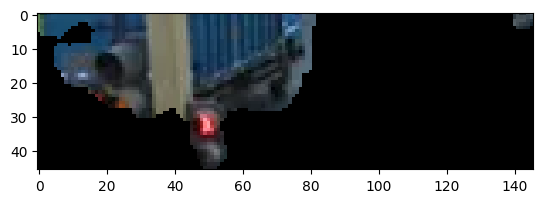

start mask


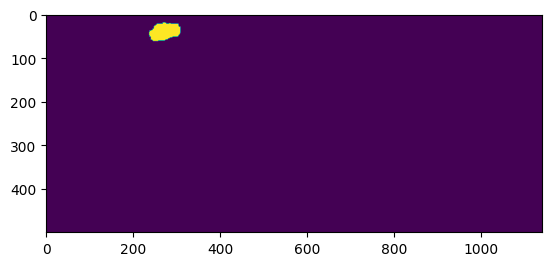

(237, 19, 309, 62)


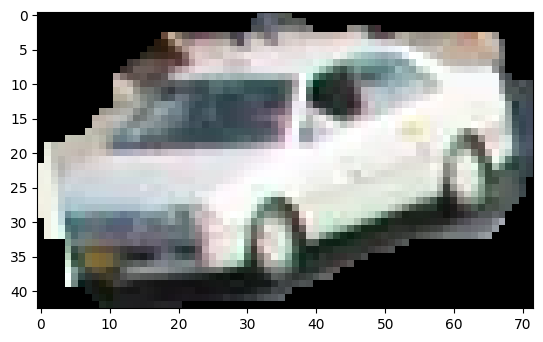

start mask


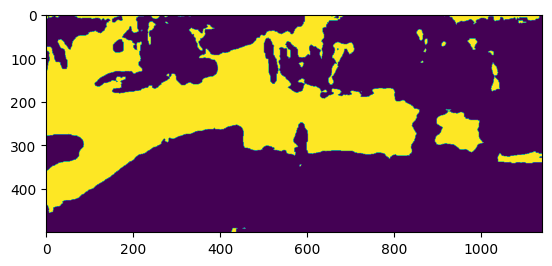

(0, 0, 1140, 500)


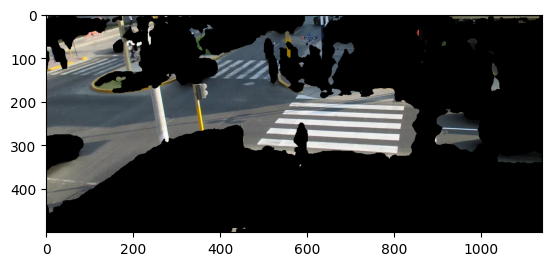

start mask


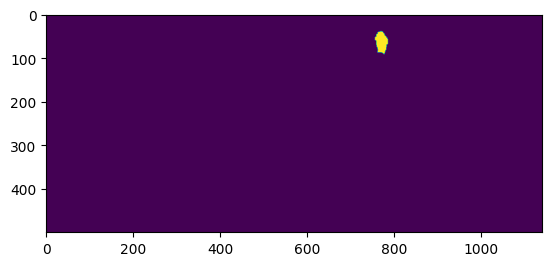

(756, 39, 786, 92)


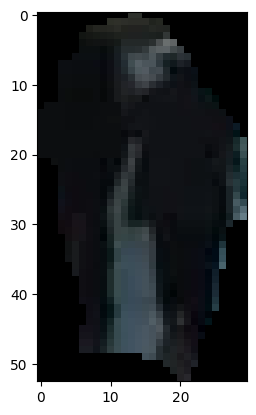

start mask


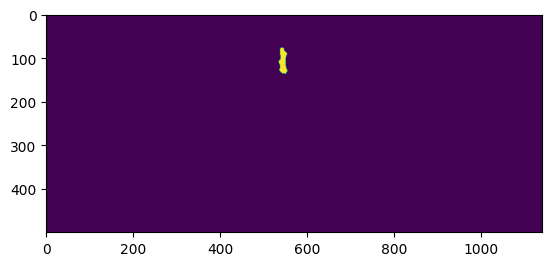

(535, 77, 555, 137)


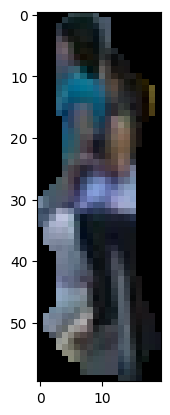

start mask
no mask for you
start mask


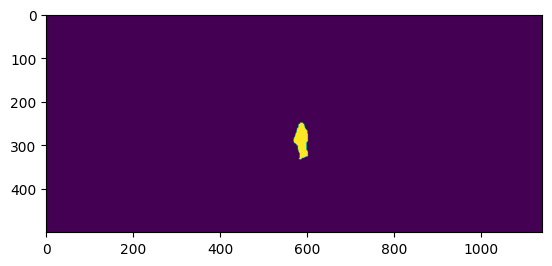

(569, 249, 602, 334)


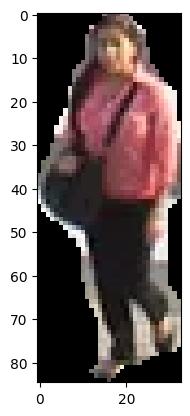

start mask


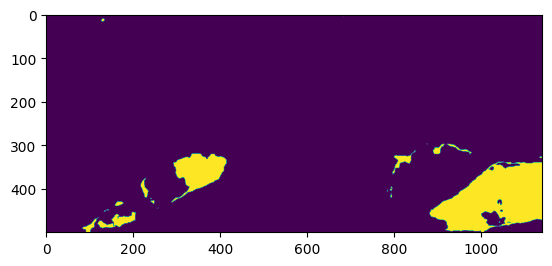

(83, 0, 1140, 500)


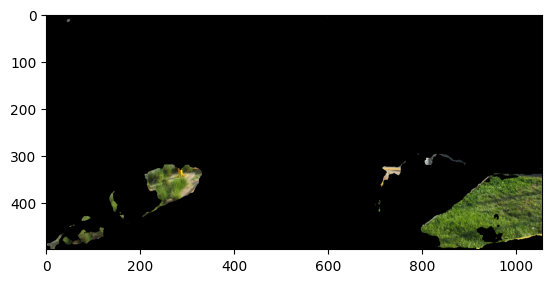

start mask


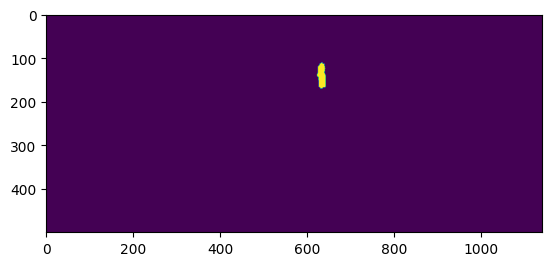

(623, 111, 643, 171)


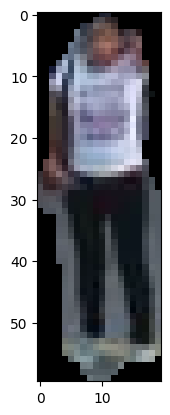

start mask


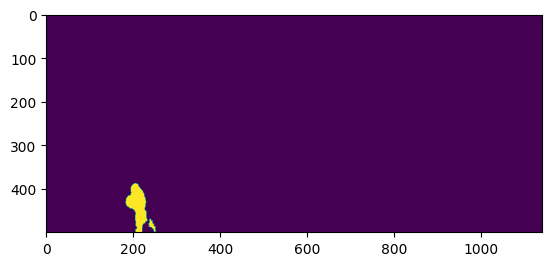

(183, 388, 252, 500)


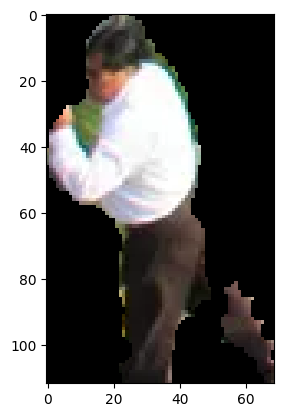

start mask


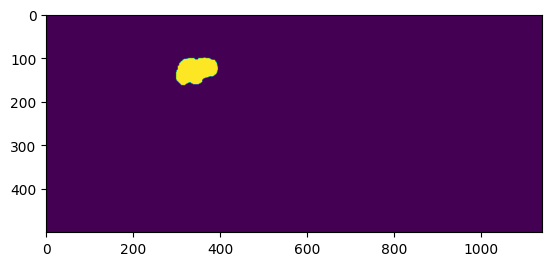

(299, 100, 395, 163)


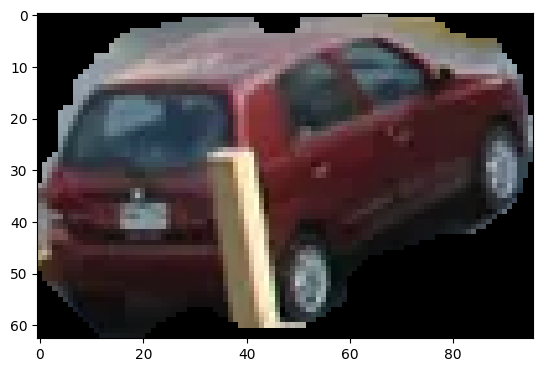

start mask


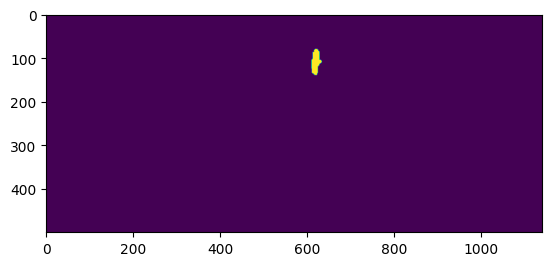

(610, 80, 634, 140)


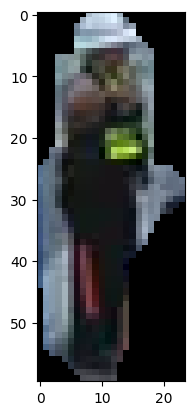

start mask


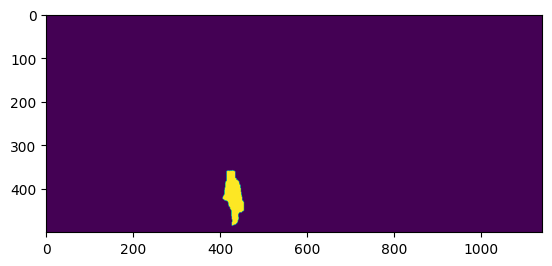

(406, 358, 455, 486)


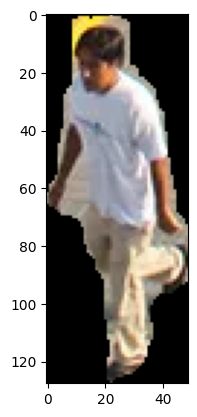

start mask


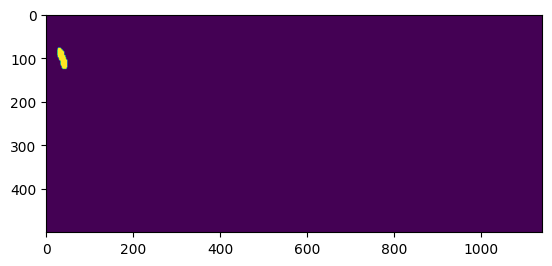

(26, 77, 49, 126)


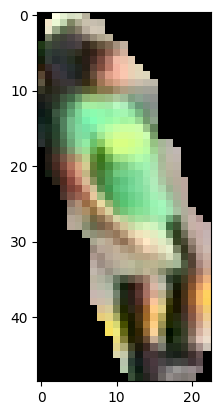

start mask


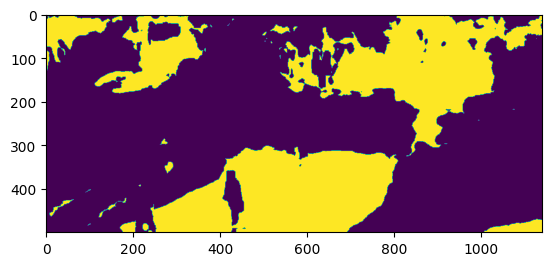

(0, 0, 1140, 500)


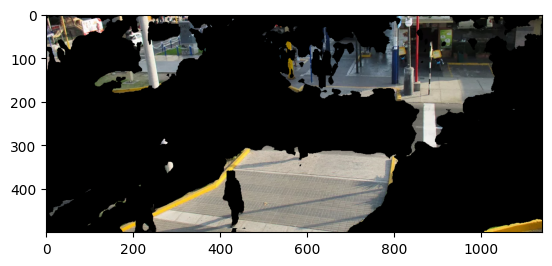

start mask


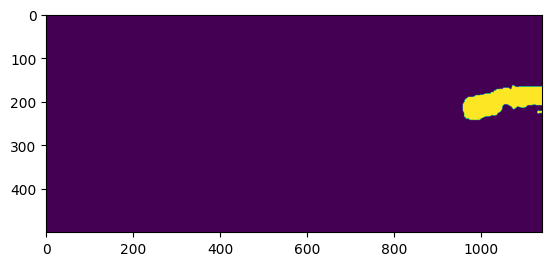

(958, 163, 1140, 243)


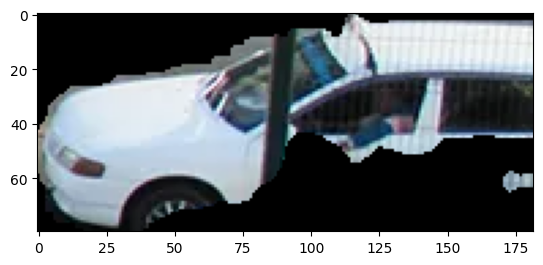

start mask
no mask for you


In [ ]:
# Extract masks from the model results
if model_type == "yolo":
  masks = [Image.fromarray(res.numpy()/255.0) for res in results[0].masks.data]
elif model_type == "segformer" or model_type=="mask2former" or model_type == "detr":
  masks = [i["mask"] for i in results]

# Process the masks and extract segments
segments = list()
newmasks = []
for mask in masks:
  print("start mask")
  image = image.resize(mask.size)
  green_image = Image.new("RGB", image.size, color=(0, 0, 0))

  if (np.sum(np.array(mask)/255) < 0.001 * np.array(mask).shape[0] * np.array(mask).shape[1] and model_type !="yolo"):
    print("no mask for you")
    continue
  plt.imshow(mask)
  plt.show()
  ar1 = np.array(mask)
  newmasks.append(mask)
  mask = Image.fromarray((255.0 - np.array(mask))).convert('L')

  ar2 = np.array(mask)
  bb = find_bounding_box(ar2)
  print(bb)
  masked_image = Image.composite(green_image,image,mask=mask).crop(bb)
  segments.append(masked_image)
  plt.imshow(masked_image)
  plt.show()

# Display the masked images
masks = newmasks

In [ ]:
# Defined a function to show the masked image
def show_masked_image(image, masks, bestseg):
  mask = np.zeros((image.size[1], image.size[0]))
  for i in bestseg:
    mask = (mask > 0) | (np.array(masks[i])/255 == 1)
  mask = mask *255
  mask = np.array(mask)
  a, b = mask.shape
  img = image.resize((b,a))
  img_array = np.array(img)
  seg_img_array = np.copy(img_array)
  seg_img = Image.fromarray(seg_img_array)
  blk_img = Image.new('RGB', img.size, (255,255,255))
  blk_img.show()
  transparency_mask = np.ones(img_array.shape[0:2], dtype=np.uint8)
  transparency_mask *= 150
  transparency_mask = np.where(mask, transparency_mask, 0)
  transparency_mask += 105
  transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
  blk_img.paste(seg_img, mask=transparency_mask_image)
  plt.imshow(blk_img)
  plt.show()

In [ ]:
# Imported CLIP models and processors
from transformers import CLIPProcessor, CLIPModel

clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

27
tensor([20.3320, 20.5886, 20.8835, 20.9402, 21.0227, 21.1557, 21.3179, 21.4665, 21.5450, 21.8980, 21.9718, 22.2737, 22.3054, 22.3126, 22.6291, 22.6843, 23.1947, 23.4335, 23.5470, 23.8153, 24.7939, 24.9073, 25.2764, 25.4035, 25.9438, 26.4851, 27.5153], grad_fn=<IndexBackward0>)
[13  9 11  6  8 26  1]


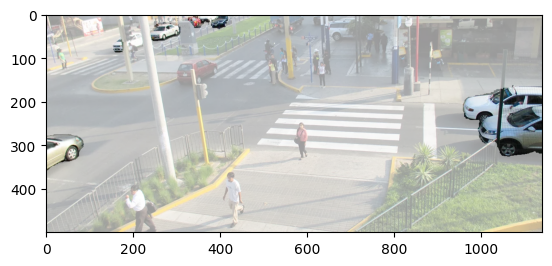

In [ ]:
# Set a prompt text description
text = "cars"
print(len(segments))

# Create inputs for CLIP model
try:
  inputs = processor(text=[text], images=segments, return_tensors="pt", padding=True)
except:
  raise "No segments created"
outputs = clip(**inputs)

# Sort segments based on probabilities
indexes = np.array((outputs.logits_per_image.softmax(dim=0).reshape(-1)).argsort())
probs = outputs.logits_per_image.reshape(-1)[indexes]
print(probs)
bestseg = indexes[-1]

# Filter segments based on a probability threshold
bestseg = indexes[np.array(probs>0.9*probs[-1])]
print(bestseg)

# Display the final masked image
show_masked_image(image, masks, bestseg)
